In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision verseion:', torchvision.__version__)
print('Is GPU avaibale:', torch.cuda.is_available())

PyTorch version: 0.4.1
torchvision verseion: 0.2.1
Is GPU avaibale: False


In [2]:
# ハイパーパラメータ等（エポック数、バッチサイズ、学習率、デバイス）
batchsize = 128
learning_rate = 0.0005
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# データセットをロード
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
mnist_train = datasets.MNIST(root = '../data',
                                 train = True,
                                 transform = tf,
                                 download = True)
mnist_validation = datasets.MNIST(root = '../data',
                                      train = False,
                                      transform = tf)

mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True)
mnist_validation_loader = DataLoader(mnist_validation, batch_size = batchsize, shuffle = True)

print('the number of training data', len(mnist_train))
print('the number of validation data', len(mnist_validation))

the number of training data 60000
the number of validation data 10000


torch.Size([1, 28, 28])


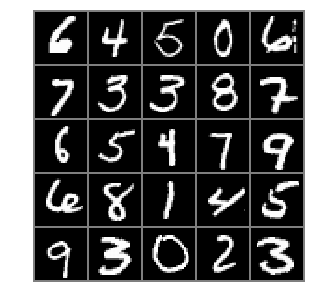

In [15]:
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.figure(figsize = (5, 5))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
images, labels = iter(mnist_train_loader).next()
imshow(make_grid(images[:25], nrow=5, padding=1))
print(images[0].size())

In [97]:
class AffineCouplingLayer(nn.Module):
    def __init__(self):
        super(AffineCouplingLayer, self).__init__()
        self.fc1 = nn.Linear(392, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 500)
        self.bn2 = nn.BatchNorm1d(500)
        self.fc3_s = nn.Linear(500, 392)
        self.fc3_t = nn.Linear(500, 392)
                
    def forward(self, x):
        x_a = x[:, :392]
        x_b = x[:, 392:]
        
        s, t = self._get_s_and_t(x_a)
        y_b = x_b * s.exp() + t
        y = torch.cat([x_a, y_b], dim=1)
        
        return y
    
    def inverse(self, y):
        y_a = y[:, :392]
        y_b = y[:, 392:]
        
        s, t = self._get_s_and_t(y_a)
        x_b = (y_b - t) / s.exp()
        x = torch.cat([y_a, x_b], dim=1)
        
        log_det_jacobian = torch.sum(s).detach().item()
        
        return x, log_det_jacobian
        
    def _get_s_and_t(self, x_a):
        fc1_out = self.fc1(x_a)
        fc1_out = self.bn1(fc1_out)
        fc1_out = F.relu(fc1_out)
        
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.bn2(fc2_out)
        fc2_out = F.relu(fc2_out)
        
        s = self.fc3_s(fc2_out)
        t = self.fc3_t(fc2_out)
        
        return s,t

In [141]:
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()
        self.affine1 = AffineCouplingLayer()
        self.affine2 = AffineCouplingLayer()
        self.affine3 = AffineCouplingLayer()
        self.affine4 = AffineCouplingLayer()
        
    def forward(self, z):
        x = self.affine1.forward(z)
        x = self._reverse(x)
        
        x = self.affine2.forward(x)
        x = self._reverse(x)
        
        x = self.affine3.forward(x)
        x = self._reverse(x)
        
        x = self.affine4.forward(x)
        
        return x
    
    def inverse(self, x):
        log_det_jacobian = 0
        
        z, temp_log_det_jacobian = self.affine4.inverse(x)
        log_det_jacobian += temp_log_det_jacobian
        z = self._reverse(z)
        
        z, temp_log_det_jacobian = self.affine3.inverse(z)
        log_det_jacobian += temp_log_det_jacobian
        z = self._reverse(z)
        
        z, temp_log_det_jacobian = self.affine2.inverse(z)
        log_det_jacobian += temp_log_det_jacobian
        z = self._reverse(z)
        
        z, temp_log_det_jacobian = self.affine1.inverse(z)
        log_det_jacobian += temp_log_det_jacobian
        
        return z, log_det_jacobian
        
    def _reverse(self, x):
        return x.flip(1)

In [142]:
net = RealNVP()
net = net.to(device)

def 

In [143]:
image  =  images[:3]

In [149]:
a, b = net.inverse(image.view(3, -1))

In [150]:
a.size()

torch.Size([3, 784])

In [151]:
b

19.15713596343994

In [120]:
a = reversed(np.array([3,3,3,5]))

In [121]:
a